## <span style="color: Orange">**Support Vector Machine Model**</span>

- End-to-end SVM workflow on Wisconsin Breast Cancer: config-driven data loading, class-balanced SVCs, stratified learning curves, cross-validated metrics, randomized hyperparameter search, permutation-based feature selection, and combined-feature retraining and evaluation.

**Table of Contents**

- [Section I: Environment Setup and Configuration](#section-i-environment-setup-and-configuration)
- [Section II: Data Loading](#section-ii-data-loading)
- [Section III: SVM Setup and Learning Curves](#section-iii-svm-setup-and-learning-curves)
- [Section IV: Cross-Validated Metrics and Hyperparameter Search](#section-iv-cross-validated-metrics-and-hyperparameter-search)
- [Section V: Validation/Test Classification Reports](#section-v-validationtest-classification-reports)
- [Section VI: Permutation Importance and Feature Selection](#section-vi-permutation-importance-and-feature-selection)
- [Section VII: Combined-Feature Training and Evaluation](#section-viI-combined-feature-training-and-evaluation)

**Notebook introduction**

This notebook builds a rigorous SVM pipeline for breast cancer classification, emphasizing reproducibility and class-sensitive evaluation. It starts with a configuration-driven setup and curated data splits in raw, engineered, and main forms. Class-balanced SVCs are trained and analyzed using stratified learning curves focused on malignant recall, followed by stratified cross-validation to summarize malignant precision/recall/F1 across folds. Randomized hyperparameter search explores kernels and regularization while refitting on malignant recall, after which tuned models are assessed via validation/test classification reports. Finally, permutation importance identifies influential features per pool; a threshold-based selection forms a combined feature set used to train and evaluate a consolidated SVM, enabling a clear comparison of preprocessing strategies and feature selection on clinically relevant metrics.


### <span style="color: Orange;">**Section I: Environment Setup and Configuration**</span>

In this section, we begin by importing all the essential Python libraries commonly used for data analysis, visualization, and preprocessing. 
- **Pandas** and **NumPy** provide robust functionality for handling structured data and efficient numerical computations.  
- **Matplotlib** and **Seaborn** are used for visualizations, enabling us to better understand trends, patterns, and distributions within the dataset.  

Following this, we load all the **notebook-specific configurations** from an external YAML file. This configuration file stores paths for different dataset splits (training, validation, and testing) in **raw**, **engineered**, and **processed** forms, both for input features (`X`) and corresponding labels (`y`).  

By structuring the data loading process via a configuration file, we ensure flexibility and easier reproducibility across experiments.


In [19]:
# Importing all of the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
# Loading the notebook cofigurations
import yaml
with open("../notebook_config.yaml", "rb") as f:
    config = yaml.safe_load(f)
    X_train_eng, X_val_eng, X_test_eng = config['paths']["X_train_eng"], config['paths']["X_val_eng"], config['paths']["X_test_eng"]
    y_train_eng, y_val_eng, y_test_eng = config['paths']["y_train_eng"], config['paths']["y_val_eng"], config['paths']["y_test_eng"]
    
    X_train_raw, X_val_raw, X_test_raw = config['paths']["X_train_raw"], config['paths']["X_val_raw"], config['paths']["X_test_raw"]
    y_train_raw, y_val_raw, y_test_raw = config['paths']["y_train_raw"], config['paths']["y_val_raw"], config['paths']["y_test_raw"]

    X_train, X_val, X_test = config['paths']["X_train"], config['paths']["X_val"], config['paths']["X_test"]
    y_train, y_val, y_test = config['paths']["y_train"], config['paths']["y_val"], config['paths']["y_test"]

### <span style="color: Orange;">**Section II: Data Loading**</span>

In this section, we load the different dataset splits into memory. The Wisconsin Breast Cancer dataset has been preprocessed and stored in three different forms:  

1. **Engineered Features (`*_eng`)**  
   - These contain features that have undergone transformations such as scaling, feature engineering, or other preprocessing steps to enhance model performance.  

2. **Raw Features (`*_raw`)**  
   - The unmodified dataset, preserved in its original state to allow for baseline comparisons and exploratory analysis without preprocessing bias.  

3. **Main Split (`X_train`, `X_val`, `X_test`)**  
   - A curated version of the dataset intended as the primary set for model training, validation, and testing. This split reflects the actual datasets that will be used across modeling experiments.  

All labels (`y`) are loaded alongside their corresponding features and immediately converted into **Series objects** (via `.squeeze()`) for easier handling in downstream tasks. By separating raw, engineered, and main splits, we can compare model performance across different preprocessing strategies in a consistent and reproducible manner.


In [21]:
# Load engineered features and labels
X_train_eng = pd.read_csv(X_train_eng)
X_val_eng = pd.read_csv(X_val_eng)
X_test_eng = pd.read_csv(X_test_eng)
y_train_eng = pd.read_csv(y_train_eng).squeeze()
y_val_eng = pd.read_csv(y_val_eng).squeeze()
y_test_eng = pd.read_csv(y_test_eng).squeeze()

# Load raw features and labels
X_train_raw = pd.read_csv(X_train_raw)
X_val_raw = pd.read_csv(X_val_raw)
X_test_raw = pd.read_csv(X_test_raw)
y_train_raw = pd.read_csv(y_train_raw).squeeze()
y_val_raw = pd.read_csv(y_val_raw).squeeze()
y_test_raw = pd.read_csv(y_test_raw).squeeze()

# Load the main split as well
X_train = pd.read_csv(X_train)
X_val = pd.read_csv(X_val)
X_test = pd.read_csv(X_test)
y_train = pd.read_csv(y_train).squeeze()
y_val = pd.read_csv(y_val).squeeze()
y_test = pd.read_csv(y_test).squeeze()

### <span style="color: Orange;">**Section III: SVM Setup and Learning Curves**</span>

- Define class-balanced RBF SVMs for engineered and raw feature spaces
- Plot cross-validated learning curves with stratified folds focusing on malignant recall
- Use consistent CV and scoring to compare data regimes fairly

This section configures two Support Vector Classifiers (SVC) with an RBF kernel and class_weight='balanced' to handle class imbalance, using gamma='scale' so the kernel adapts to feature variance while C controls the margin-regularization trade-off. Learning curves are computed to show how training and validation performance evolve as the training set size increases, helping diagnose bias/variance behavior and potential data needs. Cross-validation is stratified to preserve label proportions across folds, and a custom scorer emphasizes malignant-class recall, aligning evaluation with sensitivity to the positive class.


In [22]:
from sklearn.svm import SVC

svc_v1_eng = SVC(
    C=0.80,
    kernel='rbf',
    gamma='scale',
    class_weight='balanced',
    probability=False,
    random_state=42
)
svc_v1_raw = SVC(
    C=0.80,
    kernel='rbf',
    gamma='scale',
    class_weight='balanced',
    probability=False,
    random_state=42
)

In [23]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(model, X_train, y_train, title, cv=5, scoring='accuracy'):
    train_sizes, train_scores, val_scores = learning_curve(
        model, X_train, y_train, cv=cv, scoring=scoring,
        train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1, random_state=42)
    
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)

    plt.figure(figsize=(8,6))
    plt.plot(train_sizes, train_mean, 'o-', color='blue', label=f'Training {scoring}')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
    plt.plot(train_sizes, val_mean, 'o-', color='green', label=f'Validation {scoring}')
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='green')

    plt.title(title)
    plt.xlabel('Training Set Size')
    plt.ylabel(f'{scoring}')
    plt.legend()
    plt.grid(True)
    plt.show()

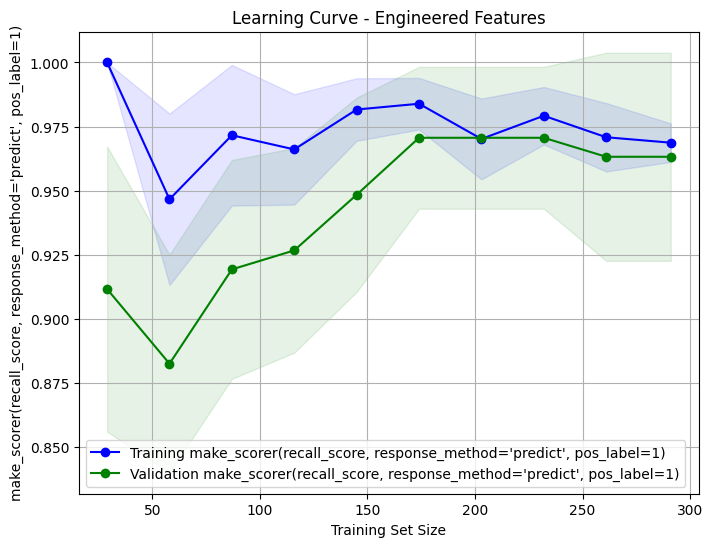

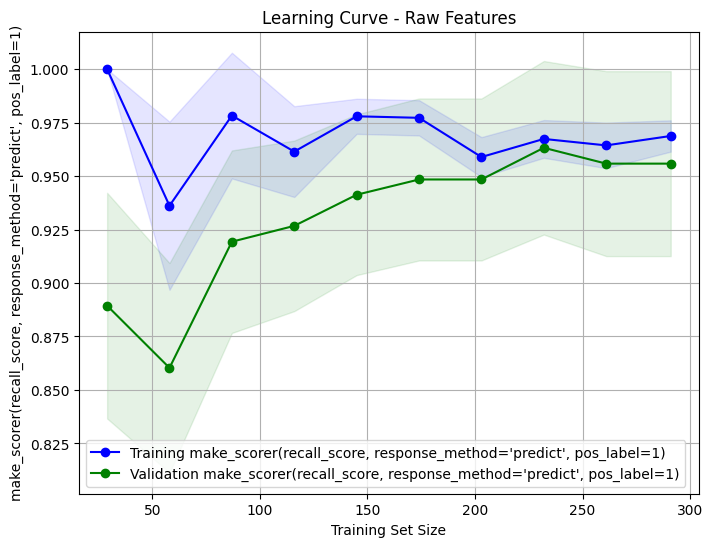

In [24]:
from sklearn.metrics import make_scorer, recall_score, precision_score, f1_score
from sklearn.model_selection import StratifiedKFold

recall_malignant = make_scorer(recall_score, pos_label=1)
precision_malignant = make_scorer(precision_score, pos_label=1)
f1_malignant = make_scorer(f1_score, pos_label=1)


stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
plot_learning_curve(
    svc_v1_eng, X_train_eng, y_train_eng, 
    'Learning Curve - Engineered Features', 
    cv=stratified_cv, scoring=recall_malignant
)
# Plot on raw features
plot_learning_curve(
    svc_v1_raw, X_train_raw, y_train_raw, 
    'Learning Curve - Raw Features', 
    cv=stratified_cv, scoring=recall_malignant
)

### <span style="color: Orange;">**Section IV: Cross-Validated Metrics and Hyperparameter Search**</span>

- Evaluate SVCs with stratified 5-fold CV on malignant- and benign-focused metrics
- Report mean ± std for recall, precision, and F1 with consistent splits across feature pools
- Run randomized hyperparameter search with multi-metric scoring and refit on malignant recall

This section extends evaluation with cross-validation and randomized hyperparameter tuning for both engineered and raw SVCs. First, stratified 5-fold cross-validation computes malignant-focused metrics (recall, precision, F1), printing mean ± standard deviation to quantify central tendency and variability for each metric under identical splits, ensuring a fair comparison between feature regimes. Next, a randomized search explores C, kernel, degree, gamma, class_weight, shrinking, and tolerance, using multi-metric scoring that tracks both malignant and benign recall while refitting on malignant recall. The best parameter sets and corresponding best estimators are retrieved alongside the full cv_results_ for further analysis, enabling selection of models that maximize sensitivity to malignant cases without neglecting benign-class performance.


In [25]:
from sklearn.model_selection import cross_validate

scoring = {
    'recall_malignant': recall_malignant,
    'precision_malignant': precision_malignant,
    'f1_malignant': f1_malignant
}

cv_results_eng = cross_validate(
    svc_v1_eng, X_train_eng, y_train_eng, 
    cv=stratified_cv, scoring=scoring, n_jobs=-1,
    return_train_score=False
)

cv_results_raw = cross_validate(
    svc_v1_raw, X_train_raw, y_train_raw,
    cv=stratified_cv, scoring=scoring, n_jobs=-1,
    return_train_score=False
)
for metric in scoring.keys():
    scores = cv_results_eng[f'test_{metric}']
    print(f"Engineered Features - {metric}: {scores.mean():.3f} ± {scores.std():.3f}")
for metric in scoring.keys():
    scores = cv_results_raw[f'test_{metric}']
    print(f"Raw Features - {metric}: {scores.mean():.3f} ± {scores.std():.3f}")

Engineered Features - recall_malignant: 0.963 ± 0.041
Engineered Features - precision_malignant: 0.970 ± 0.029
Engineered Features - f1_malignant: 0.966 ± 0.033
Raw Features - recall_malignant: 0.956 ± 0.043
Raw Features - precision_malignant: 0.950 ± 0.029
Raw Features - f1_malignant: 0.952 ± 0.026


In [26]:
from sklearn.model_selection import RandomizedSearchCV

recall_benign = make_scorer(recall_score, pos_label=0)

scoring = {
    'recall_malignant': recall_malignant,
    'recall_benign': recall_benign
}

param_dist = {
    "C": [0.01, 0.1, 1, 10, 50, 100, 500],
    "kernel": ['linear', 'poly', 'rbf', 'sigmoid'],
    "degree": [2, 3, 4, 5],
    "gamma": ['scale', 'auto', 0.001, 0.01, 0.1, 1, 10],
    'class_weight': ['balanced', None],  
    'shrinking': [True, False],
    'tol': [1e-4, 1e-3, 1e-2],
    'probability': [False],
}

svc_eng = SVC(random_state=42)
svc_raw = SVC(random_state=42)

random_search_eng = RandomizedSearchCV(
    estimator=svc_eng, 
    param_distributions=param_dist, 
    n_iter=50,
    scoring=scoring,
    refit='recall_malignant',
    cv=stratified_cv,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

random_search_eng.fit(X_train_eng, y_train_eng)
print("Best Parameters (Engineered):", random_search_eng.best_params_)

random_search_raw = RandomizedSearchCV(
    estimator=svc_raw, 
    param_distributions=param_dist, 
    n_iter=50,
    scoring=scoring,
    refit='recall_malignant',
    cv=stratified_cv,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

random_search_raw.fit(X_train_raw, y_train_raw)
print("Best Parameters (Raw):", random_search_raw.best_params_)

best_svc_eng = random_search_eng.best_estimator_
best_svc_raw = random_search_raw.best_estimator_

results_eng = random_search_eng.cv_results_
results_raw = random_search_raw.cv_results_

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters (Engineered): {'tol': 0.0001, 'shrinking': True, 'probability': False, 'kernel': 'sigmoid', 'gamma': 0.01, 'degree': 3, 'class_weight': 'balanced', 'C': 500}
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters (Raw): {'tol': 0.01, 'shrinking': False, 'probability': False, 'kernel': 'linear', 'gamma': 10, 'degree': 3, 'class_weight': 'balanced', 'C': 1}


### <span style="color: Orange;">**Section V: Validation/Test Classification Reports**</span>

- Generate validation and test reports for engineered- and raw-feature SVCs
- Summarize precision, recall, F1, and support for Benign and Malignant classes
- Enable side-by-side comparison of tuned models across splits and feature pools

This section evaluates the tuned SVCs on held-out validation and test sets for both engineered and raw feature spaces. Using the best estimators from the randomized search, predictions are computed on each split and passed to a classification report to summarize per-class precision, recall, F1-score, and support, along with aggregate metrics. These reports provide a clear, standardized view of generalization behavior and class-sensitive performance across preprocessing regimes and data splits.

In [27]:
# Classification report on the Validation Splits
from sklearn.metrics import classification_report

# Predict on validation set with best estimator from engineered feature pool
y_val_pred_eng = best_svc_eng.predict(X_val_eng)
print("Classification Report - Engineered Features Validation Set")
print(classification_report(y_val_eng, y_val_pred_eng, target_names=['Benign', 'Malignant']))

# Predict on test set with best estimator from engineered feature pool
y_test_pred_eng = best_svc_eng.predict(X_test_eng)
print("Classification Report - Engineered Features Test Set")
print(classification_report(y_test_eng, y_test_pred_eng, target_names=['Benign', 'Malignant']))

Classification Report - Engineered Features Validation Set
              precision    recall  f1-score   support

      Benign       0.95      0.91      0.93        57
   Malignant       0.86      0.91      0.89        34

    accuracy                           0.91        91
   macro avg       0.90      0.91      0.91        91
weighted avg       0.91      0.91      0.91        91

Classification Report - Engineered Features Test Set
              precision    recall  f1-score   support

      Benign       0.99      0.94      0.96        72
   Malignant       0.91      0.98      0.94        42

    accuracy                           0.96       114
   macro avg       0.95      0.96      0.95       114
weighted avg       0.96      0.96      0.96       114



In [28]:
# Predict on validation set with best estimator from raw feature pool
y_val_pred_raw = best_svc_raw.predict(X_val_raw)
print("Classification Report - Raw Features Validation Set")
print(classification_report(y_val_raw, y_val_pred_raw, target_names=['Benign', 'Malignant']))

# Predict on test set with best estimator from raw feature pool
y_test_pred_raw = best_svc_raw.predict(X_test_raw)
print("Classification Report - Raw Features Test Set")
print(classification_report(y_test_raw, y_test_pred_raw, target_names=['Benign', 'Malignant']))

Classification Report - Raw Features Validation Set
              precision    recall  f1-score   support

      Benign       0.96      0.96      0.96        57
   Malignant       0.94      0.94      0.94        34

    accuracy                           0.96        91
   macro avg       0.95      0.95      0.95        91
weighted avg       0.96      0.96      0.96        91

Classification Report - Raw Features Test Set
              precision    recall  f1-score   support

      Benign       0.99      0.97      0.98        72
   Malignant       0.95      0.98      0.96        42

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



### <span style="color: Orange;">**Section VI: Permutation Importance and Feature Selection**</span>

- Compute permutation importances for tuned SVCs on validation splits
- Visualize ranked importances with uncertainty bands and select features by threshold
- Merge selected features across pools to form a consolidated candidate set

This section estimates model-agnostic feature influence using permutation importance on the validation sets for both engineered and raw feature spaces. The routine shuffles each feature repeatedly, measuring the mean decrease in a chosen score (here, accuracy) to quantify importance, and plots importances with their standard deviations to convey variability. A simple thresholding rule then selects influential features from each pool; these are merged by max importance to produce a unified, ordered list for downstream modeling and ablation.


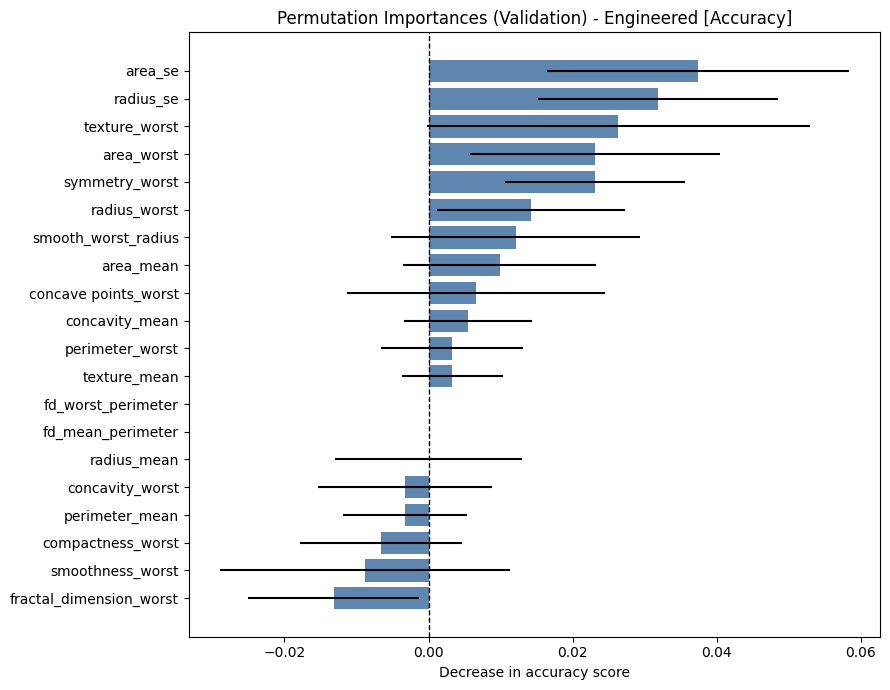

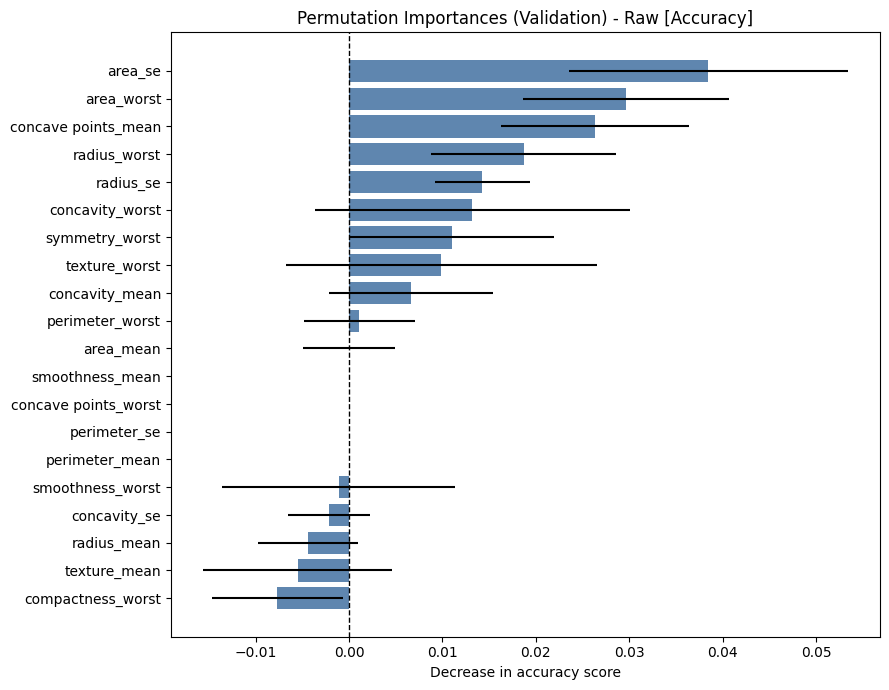

In [29]:
from sklearn.inspection import permutation_importance
import numpy as np
import matplotlib.pyplot as plt

def plot_perm_importances_hbar(importances_result, feature_names, title="Permutation Importances - Accuracy"):
    # Extract means/stds and order by mean importance (ascending for barh)
    imp_mean = importances_result.importances_mean
    imp_std  = importances_result.importances_std
    order = np.argsort(imp_mean)

    # Build horizontal bar plot
    plt.figure(figsize=(9, max(6, 0.35*len(feature_names))))
    plt.barh(np.array(feature_names)[order], imp_mean[order], xerr=imp_std[order],
             color="#4e79a7", alpha=0.9)
    plt.axvline(0.0, color="k", linestyle="--", linewidth=1)  # zero-reference line
    plt.title(title)
    plt.xlabel("Decrease in accuracy score")
    plt.tight_layout()
    plt.show()

# Compute permutation importances for SVC models (engineered and raw)
perm_importance_eng = permutation_importance(
    best_svc_eng, X_val_eng, y_val_eng,
    scoring='accuracy',  # can pass multiple scorers if desired
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

perm_importance_raw = permutation_importance(
    best_svc_raw, X_val_raw, y_val_raw,
    scoring='accuracy',
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

# Plot with the same horizontal bar style
plot_perm_importances_hbar(perm_importance_eng, X_val_eng.columns, "Permutation Importances (Validation) - Engineered [Accuracy]")
plot_perm_importances_hbar(perm_importance_raw, X_val_raw.columns, "Permutation Importances (Validation) - Raw [Accuracy]")

In [30]:
def select_features_above_threshold_perm(perm_result, feature_names, threshold):
    importances = perm_result.importances_mean
    selected = [(feature, imp) for feature, imp in zip(feature_names, importances) if imp >= threshold]
    # Sort by importance descending
    selected_sorted = sorted(selected, key=lambda x: x[1], reverse=True)
    return selected_sorted

selected_eng = select_features_above_threshold_perm(perm_importance_eng, X_val_eng.columns, threshold=0.01)
print("Selected Engineered Features:", [f[0] for f in selected_eng])


selected_raw = select_features_above_threshold_perm(perm_importance_raw, X_val_raw.columns, threshold=0.01)
print("Selected Raw Features:", [f[0] for f in selected_raw])

combined_dict = {}

for feature, importance in selected_eng + selected_raw:
    if feature in combined_dict:
        combined_dict[feature] = max(combined_dict[feature], importance)
    else:
        combined_dict[feature] = importance

combined_sorted = sorted(combined_dict.items(), key=lambda x: x[1], reverse=True)
combined_features = [f[0] for f in combined_sorted]

print("Combined Unique Features:", len(combined_features))
print("Combined Features List:", combined_features)

Selected Engineered Features: ['area_se', 'radius_se', 'texture_worst', 'area_worst', 'symmetry_worst', 'radius_worst', 'smooth_worst_radius']
Selected Raw Features: ['area_se', 'area_worst', 'concave points_mean', 'radius_worst', 'radius_se', 'concavity_worst', 'symmetry_worst']
Combined Unique Features: 9
Combined Features List: ['area_se', 'radius_se', 'area_worst', 'concave points_mean', 'texture_worst', 'symmetry_worst', 'radius_worst', 'concavity_worst', 'smooth_worst_radius']


### <span style="color: Orange;">**Section VII: Combined-Feature Training and Evaluation**</span>

- Build combined train/val/test sets from the union of selected features
- Run randomized hyperparameter search with malignant-focused refit
- Evaluate best model on validation and test splits with detailed reports

This section constructs a consolidated feature space by subsetting X_train/X_val/X_test to the union of features selected from permutation importance, keeping labels unchanged. A new SVC is tuned via randomized search over kernel, C, gamma, degree, class_weight, shrinking, and tolerance, using multi-metric scoring and refitting on malignant recall to prioritize sensitivity. The best estimator is then evaluated on validation and test sets with classification reports to quantify per-class precision, recall, F1, and overall generalization under the combined feature regime.


In [31]:
X_train_combined = X_train[combined_features]
X_val_combined = X_val[combined_features]
X_test_combined = X_test[combined_features]
y_train_combined = y_train
y_val_combined = y_val
y_test_combined = y_test

In [32]:
param_dist = {
    "C": [0.01, 0.1, 1, 10, 50, 100, 500],
    "kernel": ['linear', 'poly', 'rbf', 'sigmoid'],
    "degree": [2, 3, 4, 5],
    "gamma": ['scale', 'auto', 0.001, 0.01, 0.1, 1, 10],
    'class_weight': ['balanced', None],  
    'shrinking': [True, False],
    'tol': [1e-4, 1e-3, 1e-2],
    'probability': [False],
}

svc_combined = SVC(random_state=42)

random_search_combined = RandomizedSearchCV(
    estimator=svc_combined, 
    param_distributions=param_dist, 
    n_iter=50,
    scoring=scoring,
    refit='recall_malignant',
    cv=stratified_cv,
    n_jobs=-1,
    verbose=2,
    random_state=42
)
random_search_combined.fit(X_train_combined, y_train_combined)

print("Best Hyperparameters:", random_search_combined.best_params_)
best_svc_combined = random_search_combined.best_estimator_

y_val_pred = best_svc_combined.predict(X_val_combined)
print("Validation Classification Report:\n", classification_report(y_val_combined, y_val_pred, target_names=['Benign', 'Malignant']))

y_test_pred = best_svc_combined.predict(X_test_combined)
print("Test Classification Report:\n", classification_report(y_test_combined, y_test_pred, target_names=['Benign', 'Malignant']))


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Hyperparameters: {'tol': 0.0001, 'shrinking': True, 'probability': False, 'kernel': 'sigmoid', 'gamma': 0.01, 'degree': 3, 'class_weight': 'balanced', 'C': 500}
Validation Classification Report:
               precision    recall  f1-score   support

      Benign       0.96      0.96      0.96        57
   Malignant       0.94      0.94      0.94        34

    accuracy                           0.96        91
   macro avg       0.95      0.95      0.95        91
weighted avg       0.96      0.96      0.96        91

Test Classification Report:
               precision    recall  f1-score   support

      Benign       0.99      0.97      0.98        72
   Malignant       0.95      0.98      0.96        42

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114

